In [ ]:
# If you're on Google Colab, run this cell first
!pip install pandas numpy scikit-learn matplotlib seaborn xgboost

# Now import the libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score
from xgboost import XGBClassifier


In [ ]:
# Load the data
train_df = pd.read_csv("Train.csv")
test_df = pd.read_csv("Test.csv")
submission_df = pd.read_csv("SampleSubmission.csv")

# Display first few rows
train_df.head()


,country,year,uniqueid,bank_account,location_type,cellphone_access,household_size,age_of_respondent,gender_of_respondent,relationship_with_head,marital_status,education_level,job_type
0,Kenya,2018,uniqueid_1,Yes,Rural,Yes,3,24,Female,Spouse,Married/Living together,Secondary education,Self employed
1,Kenya,2018,uniqueid_2,No,Rural,No,5,70,Female,Head of Household,Widowed,No formal education,Government Dependent
2,Kenya,2018,uniqueid_3,Yes,Urban,Yes,5,26,Male,Other relative,Single/Never Married,Vocational/Specialised training,Self employed
3,Kenya,2018,uniqueid_4,No,Rural,Yes,5,34,Female,Head of Household,Married/Living together,Primary education,Formally employed Private
4,Kenya,2018,uniqueid_5,No,Urban,No,8,26,Male,Child,Single/Never Married,Primary education,Informally employed


In [ ]:
train_df.isnull().sum()


,0
country,0
year,0
uniqueid,0
bank_account,0
location_type,0
cellphone_access,0
household_size,0
age_of_respondent,0
gender_of_respondent,0
relationship_with_head,0


In [ ]:
print(train_df.columns.tolist())


['country', 'year', 'uniqueid', 'bank_account', 'location_type', 'cellphone_access', 'household_size', 'age_of_respondent', 'gender_of_respondent', 'relationship_with_head', 'marital_status', 'education_level', 'job_type']


In [ ]:
# Check if 'bank_account' exists in train_df
assert 'bank_account' in train_df.columns

# Encode target: Yes = 1, No = 0
y = train_df['bank_account'].map({'Yes': 1, 'No': 0})


In [ ]:
from sklearn.model_selection import train_test_split

# Drop target column from features
X = train_df.drop('bank_account', axis=1)

# Convert target to binary
y = train_df['bank_account'].map({'Yes': 1, 'No': 0})

# Split data (stratify ensures balance of 0/1 in both sets)
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y)


In [ ]:
from sklearn.preprocessing import LabelEncoder

# Combine train, valid, and test for consistent encoding
combined = pd.concat([X_train, X_valid, test_df])

# Identify categorical columns
cat_cols = combined.select_dtypes(include='object').columns.tolist()

# Apply label encoding to all categorical columns
label_encoders = {}
for col in cat_cols:
    le = LabelEncoder()
    combined[col] = le.fit_transform(combined[col].astype(str))
    label_encoders[col] = le

# Separate the sets again
X_train_encoded = combined.iloc[:X_train.shape[0]]
X_valid_encoded = combined.iloc[X_train.shape[0]:X_train.shape[0]+X_valid.shape[0]]
test_encoded = combined.iloc[X_train.shape[0]+X_valid.shape[0]:]


In [ ]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report

# Train the model
model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
model.fit(X_train_encoded, y_train)

# Predict on validation set
y_pred = model.predict(X_valid_encoded)

# Evaluate
print("✅ Accuracy:", accuracy_score(y_valid, y_pred))
print("✅ Classification Report:\n", classification_report(y_valid, y_pred))


✅ Accuracy: 0.8835364125814679
✅ Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.96      0.93      6064
           1       0.64      0.40      0.49       994

    accuracy                           0.88      7058
   macro avg       0.77      0.68      0.71      7058
weighted avg       0.87      0.88      0.87      7058



/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [17:35:33] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [ ]:
# Predict on test set
test_preds = model.predict(test_encoded)

# Prepare submission file
submission = pd.DataFrame()
submission['uniqueid x country'] = test_df['uniqueid'] + " x " + test_df['country']
submission['bank_account'] = test_preds

# Save to CSV
submission.to_csv('submission.csv', index=False)
print(" Submission file created as 'submission.csv'")


 Submission file created as 'submission.csv'


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


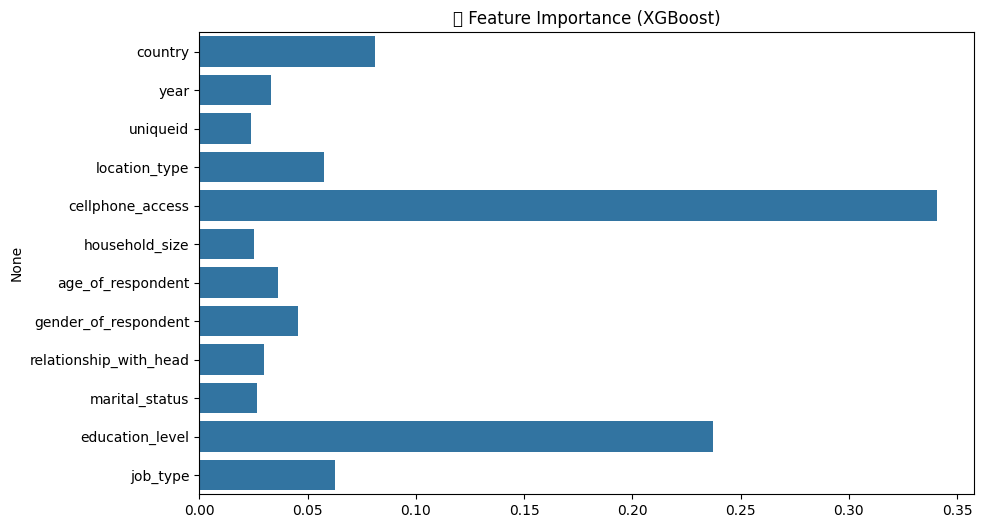

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.barplot(x=model.feature_importances_, y=X_train_encoded.columns)
plt.title("🔍 Feature Importance (XGBoost)")
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")


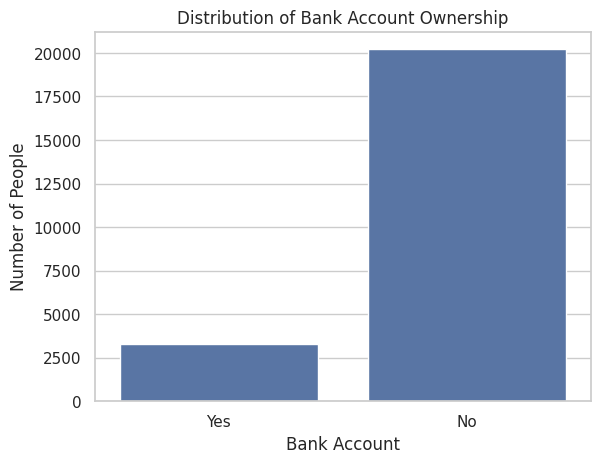

In [ ]:
sns.countplot(data=train_df, x='bank_account')
plt.title("Distribution of Bank Account Ownership")
plt.ylabel("Number of People")
plt.xlabel("Bank Account")
plt.show()


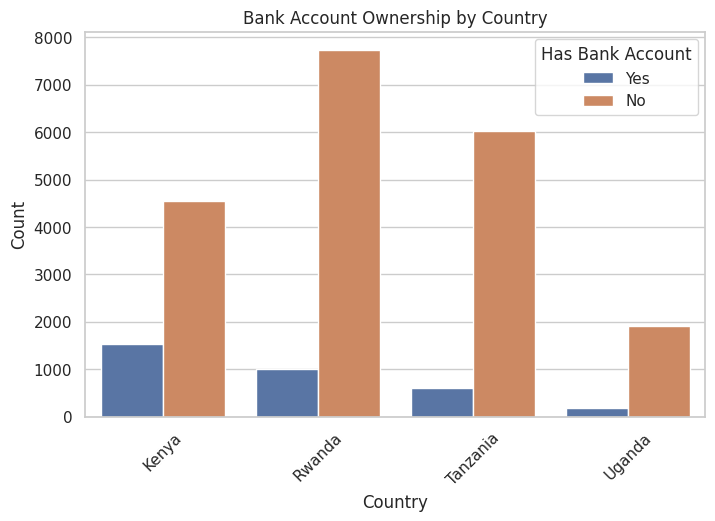

In [ ]:
plt.figure(figsize=(8, 5))
sns.countplot(data=train_df, x='country', hue='bank_account')
plt.title("Bank Account Ownership by Country")
plt.ylabel("Count")
plt.xlabel("Country")
plt.xticks(rotation=45)
plt.legend(title='Has Bank Account')
plt.show()


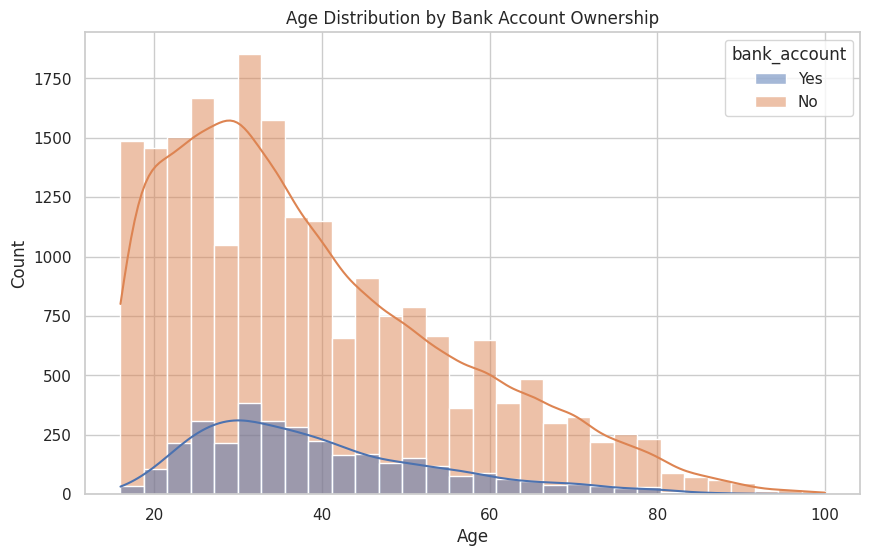

In [ ]:
plt.figure(figsize=(10,6))
sns.histplot(data=train_df, x='age_of_respondent', hue='bank_account', kde=True, bins=30)
plt.title("Age Distribution by Bank Account Ownership")
plt.xlabel("Age")
plt.ylabel("Count")
plt.show()


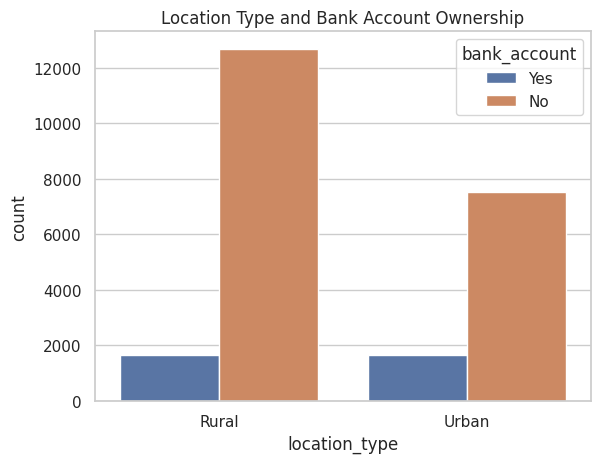

In [ ]:
sns.countplot(data=train_df, x='location_type', hue='bank_account')
plt.title("Location Type and Bank Account Ownership")
plt.show()


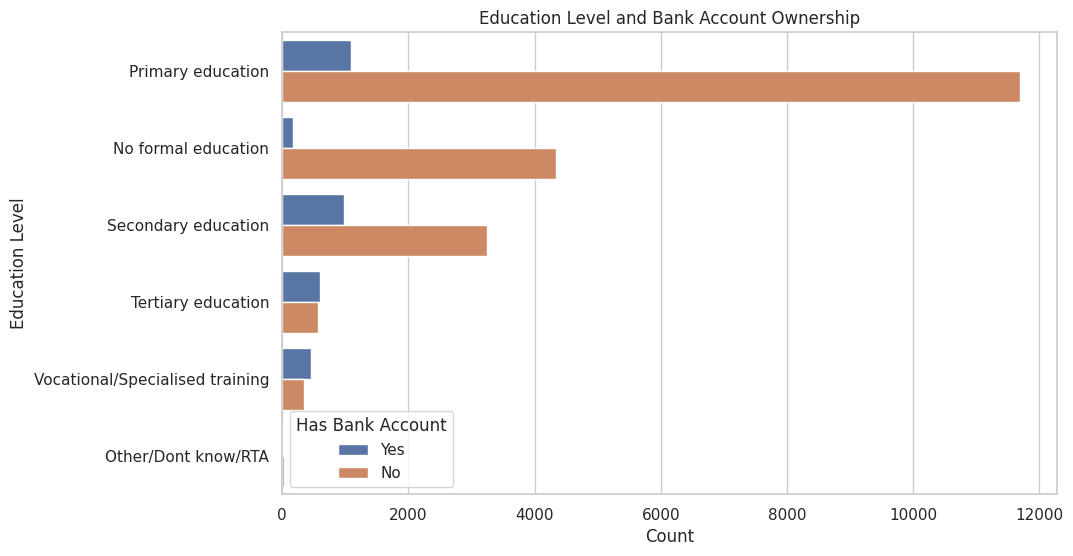

In [ ]:
plt.figure(figsize=(10,6))
sns.countplot(data=train_df, y='education_level', hue='bank_account', order=train_df['education_level'].value_counts().index)
plt.title("Education Level and Bank Account Ownership")
plt.xlabel("Count")
plt.ylabel("Education Level")
plt.legend(title='Has Bank Account')
plt.show()


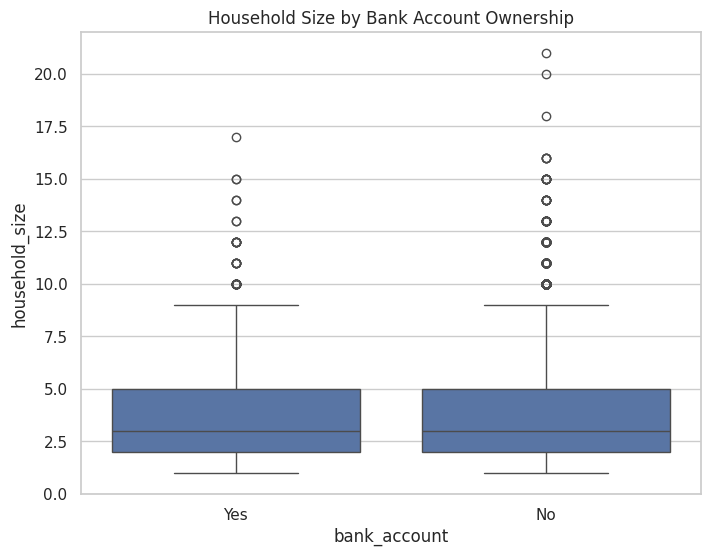

In [ ]:
plt.figure(figsize=(8, 6))
sns.boxplot(data=train_df, x='bank_account', y='household_size')
plt.title("Household Size by Bank Account Ownership")
plt.show()


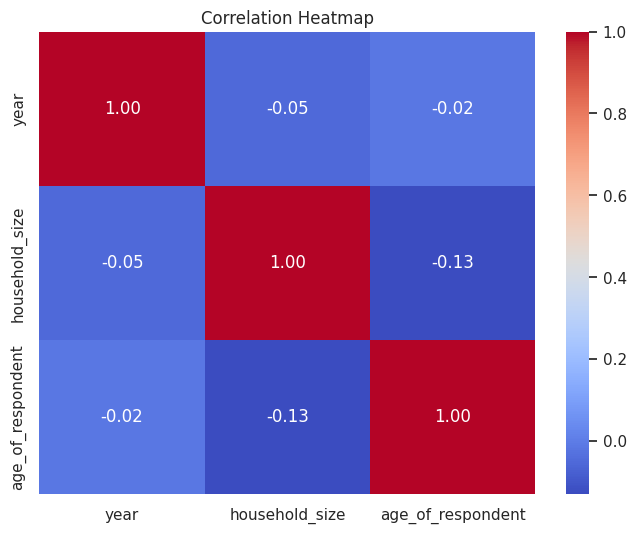

In [ ]:
plt.figure(figsize=(8, 6))
corr = train_df.select_dtypes(include='number').corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()
